# Personalised Medicine : Redefining Cancer Treatment

Cancer is leading cause of death all over the world and it is still increasing in alarming rate. The progress on
cancer treatment has been quite slow. 

This is due to the complexity nature of cancer and its appropriate treatment.
Personalized medicine and treatment are studies that takes genetic makeup into account to attempt to maximum efficiency and minimize toxicity for each patient by using the right drug with right dosage.


We are provided with a dataset of genes and cancer-related mutations, a text file of scientific literature related to each mutation, and a 1-9 classification of each case, which had been hand-annotated by a scientist at MSK after reviewing the data. 

Although we are not told in advance what each class represented, our goal is to correctly classify new test mutations after training machine learning models on the original datasets and text files. This task would ultimately help automate the work of distinguishing between driver (cancer-causing) and passenger (neutral) mutations.

In [25]:
import pandas as pd
import numpy as np
import os
from IPython.display import display, HTML
from IPython.core.interactiveshell import InteractiveShell
import warnings
import sys
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from sklearn.model_selection import StratifiedShuffleSplit
from nltk.tokenize import  word_tokenize 
import re
from nltk.util import ngrams
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
warnings.filterwarnings("ignore")

InteractiveShell.ast_node_interactivity = "all"


df_train_txt = pd.read_csv('training_text', sep='\|\|', header=None, skiprows=1, names=["ID","Text"], engine='python')
display(df_train_txt.iloc[0:5,:])

df_train_var = pd.read_csv('training_variants')
display(df_train_var.iloc[0:5,:])


df_train = pd.merge(df_train_var, df_train_txt, how='left', on='ID')
display(df_train.iloc[0:5,:])


display(df_train.iloc[0:5,:])



,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


In [2]:
import pandas as pd
import numpy as np
import os
from IPython.display import display, HTML
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


df_train_txt = pd.read_csv('training_text', sep='\|\|', header=None, skiprows=1, names=["ID","Text"], engine='python')

df_train_var = pd.read_csv('training_variants')

gene_group = df_train_var.groupby("Gene")['Gene'].count()
minimal_occ_genes = gene_group.sort_values(ascending=True)[:10]
print("Genes with maximal occurences\n", gene_group.sort_values(ascending=False)[:10])
print("\nGenes with minimal occurences\n", minimal_occ_genes)

df_train_txt=df_train_txt.dropna()
df_train_txt .loc[:, 'Text_count']  = df_train_txt["Text"].apply(lambda x: len(x.split()))
train_full =  df_train_var.merge( df_train_txt , how="inner", left_on="ID", right_on="ID")
display(train_full[train_full["Class"]==1].head())

count_grp = train_full.groupby('Class')["Text_count"]
display(count_grp.describe())


Genes with maximal occurences
 Gene
BRCA1     264
TP53      163
EGFR      141
PTEN      126
BRCA2     125
KIT        99
BRAF       93
ERBB2      69
ALK        69
PDGFRA     60
Name: Gene, dtype: int64

Genes with minimal occurences
 Gene
KLF4      1
FGF19     1
FANCC     1
FAM58A    1
PAK1      1
ERRFI1    1
PAX8      1
PIK3R3    1
PMS1      1
PPM1D     1
Name: Gene, dtype: int64


,ID,Gene,Variation,Class,Text,Text_count
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...,6089
7,7,CBL,Deletion,1,CBL is a negative regulator of activated recep...,14683
16,16,CBL,Truncating Mutations,1,To determine if residual cylindrical refractiv...,8118
37,37,DICER1,D1709E,1,Sex cord–stromal tumors and germ-cell tumors a...,2710
38,38,DICER1,D1709A,1,Sex cord–stromal tumors and germ-cell tumors a...,2710


,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
1,566.0,9483.689046,6503.595573,183.0,4976.00,7317.0,12944.50,52972.0
2,452.0,9310.393805,7627.288722,116.0,4185.00,6810.0,12220.00,61957.0
3,89.0,6757.382022,3725.366918,1737.0,4283.00,5572.0,7415.00,27391.0
4,686.0,8983.390671,7280.220754,53.0,4566.00,6351.0,11537.00,43913.0
5,242.0,7517.049587,3902.868040,183.0,5245.00,6463.0,9513.50,24226.0
6,273.0,7236.743590,3801.049711,230.0,4691.00,6587.0,7847.00,24609.0
7,952.0,11454.886555,10110.443171,448.0,4876.25,8256.5,14647.25,76782.0
8,19.0,10814.421053,5648.714095,2111.0,5586.00,11253.0,15535.00,20626.0
9,37.0,12807.459459,10217.093429,1147.0,4942.00,10930.0,15797.00,45177.0


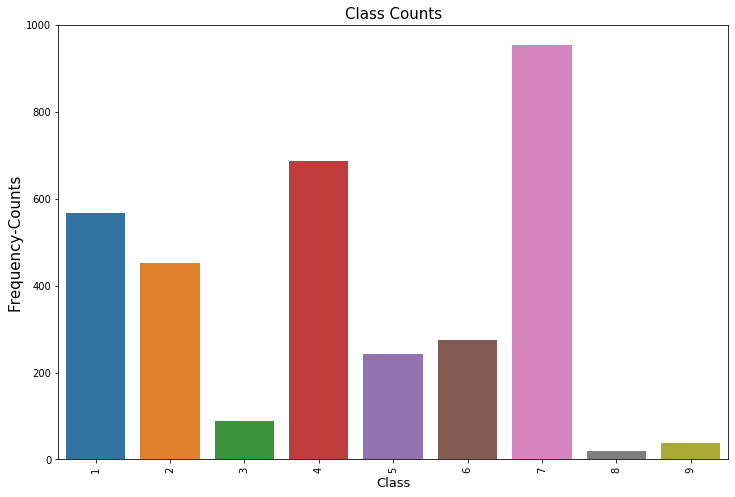

In [4]:
def checkForonlySymbols(str2):    
    ok=re.match("\S*[A-Za-z0-9]\S*",str2)
    if ok is not None:
        return False
    else:
        return True



train_variants = pd.read_csv('training_variants');
test_variants = pd.read_csv('test_variants');
train_text = pd.read_csv('training_text', sep="\|\|", engine='python', header=None, skiprows=1, names=["ID","Text"]);
test_text = pd.read_csv('test_text', sep="\|\|", engine='python', header=None, skiprows=1, names=["ID","Text"]);
train_merge = pd.merge(train_variants,train_text,how='left',on='ID');

# Histogram : To check class distribution
plt.figure(figsize=(12,8));
sns.countplot(x='Class',data=train_variants);
plt.ylabel('Frequency-Counts', fontsize=15);
plt.xlabel('Class',fontsize=13);
plt.xticks(rotation='vertical');
plt.title('Class Counts',fontsize=15);
plt.show();

train_merge["Text_num_words"] = train_merge["Text"].apply(lambda x: len(str(x).split()) );
train_merge["Text_num_chars"] = train_merge["Text"].apply(lambda x: len(str(x)) );



              Fig: Frequency histogram of number of samples in each class
              
This figures shows the count of samples in each class. From above frequency histogram it is clear that there is lot of variation between number of samples of different classes e.g. in class 7 there are 900+ samples whereas in class 8 there are even less than 100 samples. So to handle this we are going to use oversampling so that each class have equal number of samples.

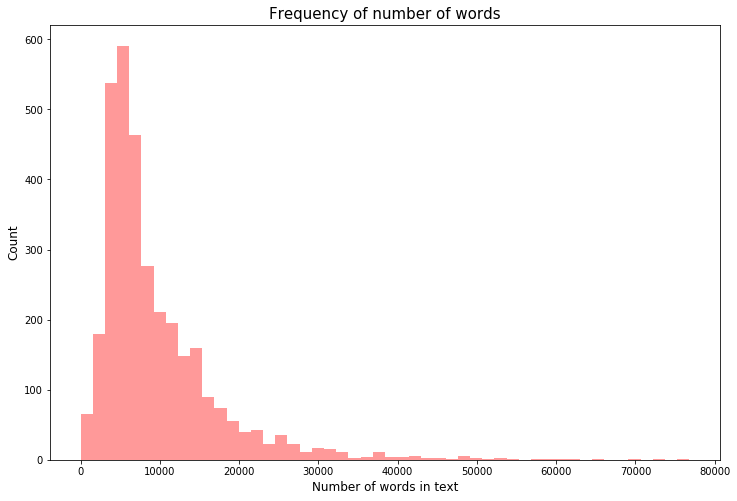

In [4]:
plt.figure(figsize=(12, 8));
sns.distplot(train_merge.Text_num_words.values, bins=50, kde=False, color='red');
plt.xlabel('Number of words in text', fontsize=12);
plt.ylabel('Count', fontsize=12);
plt.title("Frequency of number of words", fontsize=15);
plt.show();

                        Fig: Words distribution among samples
This plot shows the number of words presents in each sample. More than 80% of samples  have less than 10000 words.Almost 15% of samples have >10000 words and almost 5% of samples have words close to 2000. So in case of calculation of words in given sample, we are going to devide by the length of words present in samples due to variation between number of words present in the sample.

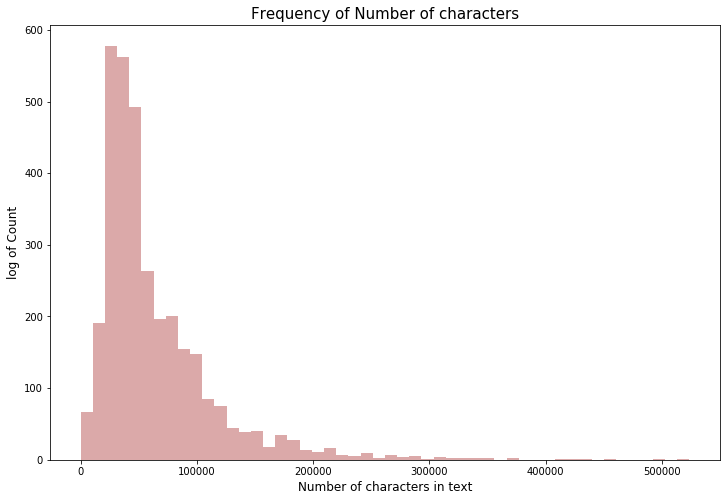

In [5]:
plt.figure(figsize=(12, 8));
sns.distplot(train_merge.Text_num_chars.values, bins=50, kde=False, color='brown');
plt.xlabel('Number of characters in text', fontsize=12);
plt.ylabel('log of Count', fontsize=12);
plt.title("Frequency of Number of characters", fontsize=15);
plt.show();

                        Fig: Character distribution among samples
This plot shows the number of Characters presents in each sample. More than 80% of samples  have less than 40000 to 70000 words.Almost 10% of samples have >100000 words and almost 7% of samples have Characters <40000. 

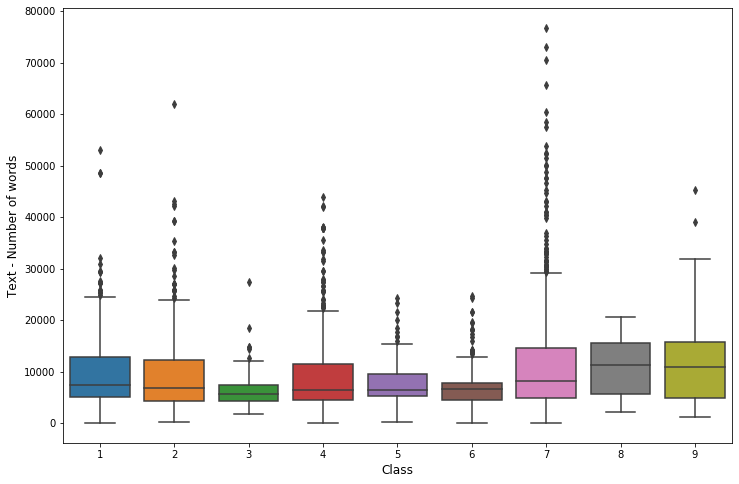

In [6]:
plt.figure(figsize=(12,8));
sns.boxplot(x='Class', y='Text_num_words', data=train_merge);
plt.xlabel('Class', fontsize=12);
plt.ylabel('Text - Number of words', fontsize=12);
plt.show();

            Fig: Box plot for number of words present in each class
This plot shows the variations of number of words present in each samples of different classes. According to this plot most of classes have samples with words varying from 0 to 30,000 And it is considering the outlier if a sample have greater than a certain threshold depands on the class. because there is very rare samples which have more than 20,000 words that's why it is considering them outlier in most of the classes.

**OVERSAMPLING** :
As we have seen that classes are imbalanced. Number of samples in classes 3,8 and 9 are quite less. This might be problem in case of predictive modelling. Hence we have applied oversampling to handle this imbalancing. 


In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
import scikitplot.plotters as skplt
import nltk
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from gensim.models import Doc2Vec
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler 
from sklearn.model_selection import train_test_split

df_train_txt = pd.read_csv('training_text', sep='\|\|', header=None, skiprows=1, names=["ID","Text"])

df_train_var = pd.read_csv('training_variants')

df_test_txt = pd.read_csv('test_text', sep='\|\|', header=None, names=["ID","Text"])

df_test_var = pd.read_csv('test_variants')

df_train = pd.merge(df_train_var, df_train_txt, how='left', on='ID')
display(df_train.head())
df_test = pd.merge(df_test_var, df_test_txt, how='left', on='ID')
display(df_test.head())

df_train, _ = train_test_split(df_train, test_size=0.80, random_state=8, stratify=df_train['Class'])
df_train=df_train.dropna()
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(np.array(df_train), np.array(df_train['Class']))
df_train=pd.DataFrame(X_res)
df_class=pd.DataFrame(y_res)
df_train.to_csv('ds_project/big_data.csv',index=False) 
df_class.to_csv('ds_project/big_outputs.csv', index=False) 

df_train=pd.read_csv('ds_project/big_data.csv')
y_res=pd.read_csv('ds_project/big_outputs.csv')
df_train,df_test,y_train,y_test = train_test_split(df_train,y_res, test_size=0.2, random_state=8, stratify=df_class)


df_train.to_csv('ds_project/train.csv', index=False) 
df_test.to_csv('ds_project/test.csv', index=False) 
y_train.to_csv('ds_project/ytrain.csv', index=False) 
y_test.to_csv('ds_project/ytest.csv', index=False) 

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


,ID,GENE,VARIATION,CLASS,Text
0,0,CBL,H398Q,4,Oncogenic mutations in the monomeric Casitas B...
1,1,CBL,S80N,6,Abstract Background Non-small cell lung canc...
2,2,SHOC2,M173I,4,Rasopathies are phenotypically similar syndrom...
3,3,DICER1,D1709N,4,Abstract DICER1 plays a critical role in mic...
4,4,PTPRT,S492F,1,The receptor protein tyrosine phosphatase T (P...


In [ ]:
from sklearn.externals import joblib 


df_train=pd.read_csv('ds_project/train.csv') 
df_test=pd.read_csv('ds_project/test.csv') 
y_train=pd.read_csv('ds_project/ytrain.csv') 
y_test=pd.read_csv('ds_project/ytest.csv') 

def evaluate_features(X, y, clf=None):
    print(y)
    if clf is None:
        clf=RandomForestClassifier()
        #clf = LogisticRegression()
    clf.fit(X,y)
    
    probas = cross_val_predict(clf, X, y, cv=StratifiedKFold(random_state=8),n_jobs=-1, method='predict_proba', verbose=2)
    pred_indices = np.argmax(probas, axis=1)
    classes = np.unique(y)
    preds = classes[pred_indices]
    print(probas)
    print(preds.shape)
    print(y.shape)
    y=y.astype(int)
    preds=preds.astype(int)
    #print('Log loss:',log_loss(y, probas))
    print("--------------validation statistics--------------")
    print('Accuracy',accuracy_score(np.array(y), np.array(preds)))
    skplt.plot_confusion_matrix(y, preds);
    print('kappa : ',cohen_kappa_score(y, preds))
    
    print("f1_score",f1_score(y, preds,average='weighted'))
    print("precision",precision_score(y, preds,average='weighted'))
    print("recall",recall_score(y, preds,average='weighted')) 
    return clf


count_vectorizer = CountVectorizer(analyzer="word", tokenizer=nltk.word_tokenize,preprocessor=None,max_features=None)  

bag_of_words = count_vectorizer.fit_transform(df_train.iloc[:,4])
joblib.dump(model, 'nlp_ass6_final_model.pkl')
model=joblib.load('nlp_ass6_final_model.pkl')
test_bag_of_words = count_vectorizer.transform(df_test.iloc[:,4])

svd = TruncatedSVD(n_components=25, n_iter=25, random_state=12)
truncated_bag_of_words = svd.fit_transform(bag_of_words)
test_bag_of_words=svd.transform(test_bag_of_words)

model=evaluate_features(truncated_bag_of_words, y_train.values.ravel(),RandomForestClassifier(n_estimators=1000, max_depth=5, verbose=1))
y_pred=model.predict(test_bag_of_words)
df_pred=pd.DataFrame(y_pred)
df_pred.to_csv('ds_project/countV.csv',index=False) 


print("-------------------Test statistics------------------------")
print('Accuracy',accuracy_score(np.array(y_test), np.array(y_pred)))
skplt.plot_confusion_matrix(y_test, y_pred)
print('kappa : ',cohen_kappa_score(y_test, y_pred))

print("f1_score",f1_score(y_test, y_pred,average='weighted'))
print("precision",precision_score(y_test, y_pred,average='weighted'))
print("recall",recall_score(y_test, y_pred,average='weighted')) 


after count
before svd
before model
     4
0    7
1    2
2    7
3    4
4    3
..  ..
525  5
526  5
527  4
528  1
529  7

[530 rows x 1 columns]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.1s finished


-------------------Test statistics------------------------
Accuracy 0.45864661654135336


kappa :  0.29239636444247397
f1_score 0.39914149923303244
precision 0.44813288844299654
recall 0.45864661654135336


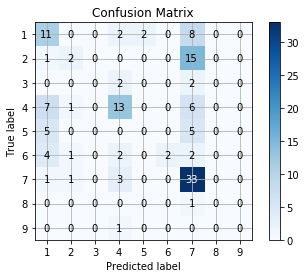

In [23]:
 
    
tf_idf_vectorizer = TfidfVectorizer(analyzer="word", tokenizer=nltk.word_tokenize,preprocessor=None, max_features=None)    

bag_of_words = tf_idf_vectorizer.fit_transform(df_train.iloc[:,4])
test_bag_of_words = tf_idf_vectorizer.transform(df_test.iloc[:,4])

svd = TruncatedSVD(n_components=25, n_iter=25, random_state=12)
truncated_bag_of_words = svd.fit_transform(bag_of_words)
test_bag_of_words=svd.transform(test_bag_of_words)

model=evaluate_features(truncated_bag_of_words, y_train.values.ravel(),RandomForestClassifier(n_estimators=1000, max_depth=5, verbose=1))
y_pred=model.predict(test_bag_of_words)
df_pred=pd.DataFrame(y_pred)
df_pred.to_csv('ds_project/tf_idf.csv',index=False) 

print("-------------------Test statistics------------------------")
print('Accuracy',accuracy_score(np.array(y_test), np.array(y_pred)))
skplt.plot_confusion_matrix(y_test, y_pred)
print('kappa : ',cohen_kappa_score(y_test, y_pred))

print("f1_score",f1_score(y_test, y_pred,average='weighted'))
print("precision",precision_score(y_test, y_pred,average='weighted'))
print("recall",recall_score(y_test, y_pred,average='weighted')) 




In [ ]:
from nltk.corpus import stopwords
import gensim
from gensim.models.doc2vec import LabeledSentence
from gensim import utils
import string
import re


def constructLabeledSentences(data):
    sentences=[]
    for index, row in data.iteritems():
        sentences.append(LabeledSentence(utils.to_unicode(row).split(), ['Text' + '_%s' % str(index)]))
    return sentences

def textClean(text):
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = text.lower().split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]    
    text = " ".join(text)
    return(text)
    
def cleanup(text):
    text = textClean(text)
    text= text.translate(str.maketrans("","", string.punctuation))
    return text

"""df_text=df_train.iloc[:,4]
allText = df_text.apply(cleanup)
sentences = constructLabeledSentences(allText)



#text_model = Doc2Vec.load("prooject_ds_doc2vec_model")
text_model = Doc2Vec(min_count=1, window=5, size=300, sample=1e-4, negative=5, workers=4, iter=5,seed=1)
text_model.build_vocab(sentences)
text_model.train(sentences, total_examples=text_model.corpus_count, epochs=text_model.iter)
text_model.save("ds_project/prooject_ds_doc2vec_model")"""


test_text=df_test.iloc[:,4]
allText = test_text.apply(cleanup)
test_sentences = constructLabeledSentences(allText)
text_model = gensim.models.doc2vec.Doc2Vec.load('ds_project/prooject_ds_doc2vec_model')
text_train_arrays = np.zeros((len(df_text), 300))
test_train_arrays = np.zeros((len(test_text), 300))




for i in range(len(df_text)):
    text_train_arrays[i] = text_model.docvecs[i]


for i in range(len(test_text)):
    test_train_arrays[i] = text_model.infer_vector(allText[i].split(" "))
    
svd = TruncatedSVD(n_components=25, n_iter=25, random_state=12)
truncated_bag_of_words= svd.fit_transform(text_train_arrays)
test_bag_of_words = svd.transform(test_train_arrays)
model=evaluate_features(truncated_bag_of_words, y_train.values.ravel(),RandomForestClassifier(n_estimators=1000, max_depth=5, verbose=1))
y_pred=model.predict(test_bag_of_words)

print("-------------------Test statistics------------------------")
print('Accuracy',accuracy_score(np.array(y_test), np.array(y_pred)))
skplt.plot_confusion_matrix(y_test, y_pred)
print('kappa : ',cohen_kappa_score(y_test, y_pred))

print("f1_score",f1_score(y_test, y_pred,average='weighted'))
print("precision",precision_score(y_test, y_pred,average='weighted'))
print("recall",recall_score(y_test, y_pred,average='weighted')) 

